# Comparison - NWP and OF

**NWP: numerical weather predictions**

**OF: optical flow**

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import preprocessing

import os

from satprod.data_handlers.num_data import NumericalDataHandler
from satprod.data_handlers.data_utils import (
    sin_transform, cos_transform, get_columns, max_min_scale_df, wind_degrees_to_polar,
)

In [2]:
%%capture
# root directory
root = '..'

# parknames
parks = ['bess', 'vals', 'yvik']
park_name = {
    'bess': 'Bessakerfjellet', 
    'skom': 'Skomakerfjellet', 
    'vals': 'Valsneset', 
    'yvik': 'Ytre Vikna'
}

# imgType
imgTypes = ['fb_dense', 'dtvl1_dense', 'rlof_dense', 'lk_dense']
imgType_name = {
    'fb_dense': 'Farnebäck', 
    'dtvl1_dense': 'Dual TV-L1', 
    'rlof_dense': 'RLOF', 
    'lk_dense': 'Lucas-Kanade'
}

# paths to optical flow results
path = os.path.join(root, 'data', 'of_num_results')

# tests are done for a specific period
start = '2018-03-20 00:00:00'
stop = '2019-03-19 23:00:00'
start_date = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
stop_date = datetime.strptime(stop, '%Y-%m-%d %H:%M:%S')

# get data and store in variable 'data'
num = NumericalDataHandler()
data = num.read_old_formatted_data(nan=False)
data = data.loc[start:stop]

def get_polar_directions(data: pd.DataFrame, park: str):
    sin = data[f'wind_direction_{park}_sin'].values
    cos = data[f'wind_direction_{park}_cos'].values
    return wind_degrees_to_polar(sin, cos)

# convert to polar degrees
for park in parks:
    polar_directions = get_polar_directions(data, park)
    data[f'wind_direction_{park}_sin'] = np.sin(polar_directions*np.pi/180)
    data[f'wind_direction_{park}_cos'] = np.cos(polar_directions*np.pi/180)

# drop production data
data = data.drop(columns=get_columns(data, 'prod').columns)

# drop forecast data
data = data.drop(columns=get_columns(data, '+').columns)

speed = max_min_scale_df(get_columns(data, 'speed'))
direction = get_columns(data, 'direction')

def get_OF_results():
    final_df = pd.DataFrame()
    path = os.path.join(root, 'data', 'of_num_results')
    for imgType in imgTypes:
        df = pd.DataFrame()
        for date in pd.date_range(start=start_date, end=stop_date, freq='D'):
            name = date.strftime('%Y-%m-%d-%H') + f'-15min-20sc.csv'
            try:
                df_new = pd.read_csv(f'{path}/{imgType}/{name}')
            except:
                continue
            df_new['time'] = pd.to_datetime(df_new['Unnamed: 0'])
            df_new = df_new.set_index(['time'])
            df_new = df_new.drop(columns=['Unnamed: 0'])
            df = pd.concat([df, df_new], axis=0)
        df2 = pd.DataFrame(index = pd.date_range(start=start_date, end=stop_date, freq='H'))
        df3 = pd.merge(df2, df, left_index = True, right_index = True, how = 'left')

        for park in parks:
            for measure in ['pixel', 'median']:
                df3[f'{park}_deg_{measure}_sin'] = np.sin(df3[f'{park}_deg_{measure}'].values*np.pi/180)
                df3[f'{park}_deg_{measure}_cos'] = np.cos(df3[f'{park}_deg_{measure}'].values*np.pi/180)
                df3 = df3.drop(columns=[f'{park}_deg_{measure}'])
        df3[[col for col in df3.columns if 'mag' in col]] = max_min_scale_df(
            df3[[col for col in df3.columns if 'mag' in col]])

        col_names = []
        for col in df3.columns:
            col_names.append(col+f'_{imgType}')
           
        df3.columns = col_names
        df3 = df3.asfreq('H')
        final_df = pd.concat([final_df, df3], axis=1)
    return final_df

of_results = get_OF_results()

all_data = pd.concat([of_results, speed, direction], axis=1)

In [3]:
start_date, stop_date

(datetime.datetime(2018, 3, 20, 0, 0), datetime.datetime(2019, 3, 19, 23, 0))

In [4]:
all_data.columns

Index(['skom_deg_pixel_fb_dense', 'skom_deg_median_fb_dense',
       'vals_mag_pixel_fb_dense', 'yvik_mag_pixel_fb_dense',
       'bess_mag_pixel_fb_dense', 'skom_mag_pixel_fb_dense',
       'vals_mag_median_fb_dense', 'yvik_mag_median_fb_dense',
       'bess_mag_median_fb_dense', 'skom_mag_median_fb_dense',
       'bess_deg_pixel_sin_fb_dense', 'bess_deg_pixel_cos_fb_dense',
       'bess_deg_median_sin_fb_dense', 'bess_deg_median_cos_fb_dense',
       'vals_deg_pixel_sin_fb_dense', 'vals_deg_pixel_cos_fb_dense',
       'vals_deg_median_sin_fb_dense', 'vals_deg_median_cos_fb_dense',
       'yvik_deg_pixel_sin_fb_dense', 'yvik_deg_pixel_cos_fb_dense',
       'yvik_deg_median_sin_fb_dense', 'yvik_deg_median_cos_fb_dense',
       'skom_deg_pixel_dtvl1_dense', 'skom_deg_median_dtvl1_dense',
       'vals_mag_pixel_dtvl1_dense', 'yvik_mag_pixel_dtvl1_dense',
       'bess_mag_pixel_dtvl1_dense', 'skom_mag_pixel_dtvl1_dense',
       'vals_mag_median_dtvl1_dense', 'yvik_mag_median_dtvl1_dense',

In [5]:
missing_values = get_columns(all_data.drop(
    columns=get_columns(all_data, 'pixel').columns),'bess').isnull().sum() / len(all_data)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values = missing_values.to_frame()
missing_values.columns = ['portion missing']
missing_values.index.names = ['feature']
missing_values['feature'] = missing_values.index

In [6]:
missing_values

,portion missing,feature
feature,,
wind_speed_bess,0.047260,wind_speed_bess
wind_direction_bess_cos,0.047260,wind_direction_bess_cos
wind_direction_bess_sin,0.047260,wind_direction_bess_sin
bess_mag_median_fb_dense,0.668721,bess_mag_median_fb_dense
bess_deg_median_sin_fb_dense,0.668721,bess_deg_median_sin_fb_dense
bess_deg_median_cos_fb_dense,0.668721,bess_deg_median_cos_fb_dense
bess_mag_median_dtvl1_dense,0.668721,bess_mag_median_dtvl1_dense
bess_deg_median_sin_dtvl1_dense,0.668721,bess_deg_median_sin_dtvl1_dense
bess_deg_median_cos_dtvl1_dense,0.668721,bess_deg_median_cos_dtvl1_dense


In [7]:
'''plt.figure(figsize=(16,8))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'feature', y = 'portion missing', data=missing_values)
plt.xticks(rotation = 90)
plt.show()'''

'plt.figure(figsize=(16,8))\nsns.set(style="whitegrid", color_codes=True)\nsns.barplot(x = \'feature\', y = \'portion missing\', data=missing_values)\nplt.xticks(rotation = 90)\nplt.show()'

## Plot

In [8]:
all_data.iloc[500:1000]

,skom_deg_pixel_fb_dense,skom_deg_median_fb_dense,vals_mag_pixel_fb_dense,yvik_mag_pixel_fb_dense,bess_mag_pixel_fb_dense,skom_mag_pixel_fb_dense,vals_mag_median_fb_dense,yvik_mag_median_fb_dense,bess_mag_median_fb_dense,skom_mag_median_fb_dense,...,yvik_deg_median_cos_lk_dense,wind_speed_bess,wind_speed_vals,wind_speed_yvik,wind_direction_bess_cos,wind_direction_bess_sin,wind_direction_vals_cos,wind_direction_vals_sin,wind_direction_yvik_cos,wind_direction_yvik_sin
2018-04-09 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.313701,0.138776,0.161816,-0.986123,-0.166017,-0.932703,-0.360644,-0.854819,-0.518927
2018-04-09 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.336566,0.141431,0.144095,-0.999870,0.016103,-0.968987,-0.247111,-0.928709,-0.370809
2018-04-09 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.360420,0.163701,0.109580,-0.994024,0.109159,-0.996470,-0.083954,-0.999183,-0.040415
2018-04-09 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.376525,0.161227,0.095773,-0.979703,0.200456,-0.997288,-0.073597,-0.937083,0.349106
2018-04-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.381564,0.209880,0.094414,-0.967891,0.251370,-0.999954,0.009599,-0.911263,0.411825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-30 11:00:00,215.152023,224.892944,0.017952,0.012940,0.007819,0.009014,0.015285,0.011204,0.008770,0.008986,...,0.208779,0.137974,0.207443,0.225765,-0.997744,-0.067133,-0.345338,-0.938478,-0.343911,-0.939002
2018-04-30 12:00:00,147.273468,149.436981,0.015111,0.027620,0.024867,0.023878,0.013702,0.025127,0.023010,0.022750,...,-0.042051,0.168475,0.104799,0.196368,-0.998132,0.061101,-0.869275,-0.494329,-0.487089,-0.873352
2018-04-30 13:00:00,51.521606,59.273743,0.022306,0.025083,0.025077,0.024891,0.020535,0.027041,0.025150,0.024136,...,0.299928,0.175313,0.130576,0.237806,-0.999998,-0.002017,-0.806351,-0.591438,-0.538935,-0.842348
2018-04-30 14:00:00,36.979889,47.317383,0.014571,0.029699,0.019606,0.016801,0.015038,0.021740,0.015071,0.014595,...,0.995559,0.198957,0.226114,0.265664,-0.994478,-0.104950,-0.453703,-0.891153,-0.579905,-0.814684


In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

from matplotlib import cycler
colors = cycler('color',
                ['#00C700', '#1F3DFF', '#4FFF57', '#000066',
                 '#F2D42E', '#FF5924', '#C4000D', '#FFA6BD',
                 '#FF2459', '#540AFF'])

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)#, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray', labelsize=20)
plt.rc('ytick', direction='out', color='gray', labelsize=20)
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def get_plots(park: str, imgType: str, start_idx, stop_idx):
    plt.figure(figsize=(16,4))
    plt.title(f'Cosine of wind direction and flow direction at {park_name[park]}')
    plt.plot(
        all_data[f'{park}_deg_median_cos_{imgType}'].index[start_idx:stop_idx],
        all_data[f'{park}_deg_median_cos_{imgType}'].iloc[start_idx:stop_idx], 
        label=imgType_name[imgType]
    )
    plt.plot(
        all_data[f'wind_direction_{park}_cos'].index[start_idx:stop_idx], 
        all_data[f'wind_direction_{park}_cos'].iloc[start_idx:stop_idx], 
        label='NWP', color='k')
    plt.xlabel('date')
    plt.ylabel(r'$\cos{\theta}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{park}_deg_median_cos_{imgType}.png')
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title(f'Sine of wind direction and flow direction at {park_name[park]}')
    plt.plot(all_data[f'{park}_deg_median_sin_{imgType}'].iloc[start_idx:stop_idx], label=imgType_name[imgType])
    plt.plot(all_data[f'wind_direction_{park}_sin'].iloc[start_idx:stop_idx], label='NWP', color='k')
    plt.xlabel('date')
    plt.ylabel(r'$\sin{\theta}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{park}_deg_median_sin_{imgType}.png')
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title(f'Normalised wind speed and flow magnitude at {park_name[park]}')
    plt.plot(all_data[f'{park}_mag_median_{imgType}'].iloc[start_idx:stop_idx], label=imgType_name[imgType])
    plt.plot(all_data[f'wind_speed_{park}'].iloc[start_idx:stop_idx], label='NWP', color='k')
    plt.xlabel('date')
    plt.ylabel('normalised magnitude')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{park}_mag_median_{imgType}.png')
    plt.show()

In [24]:
all_data.iloc[4032-24*3]

skom_deg_pixel_fb_dense          NaN
skom_deg_median_fb_dense         NaN
vals_mag_pixel_fb_dense          NaN
yvik_mag_pixel_fb_dense          NaN
bess_mag_pixel_fb_dense          NaN
                              ...   
wind_direction_bess_sin     0.433293
wind_direction_vals_cos    -0.586470
wind_direction_vals_sin     0.809971
wind_direction_yvik_cos    -0.553044
wind_direction_yvik_sin     0.833152
Name: 2018-09-01 00:00:00, Length: 97, dtype: float64

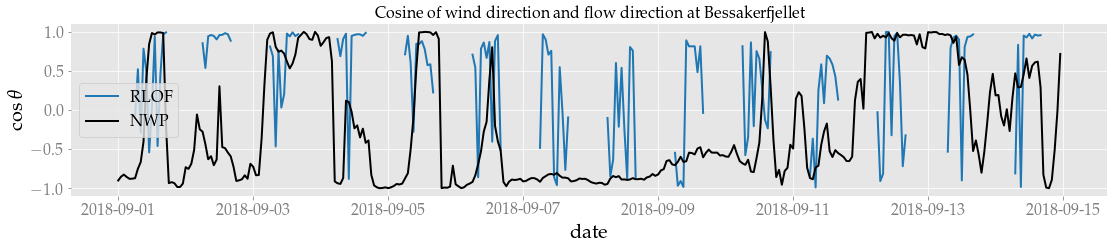

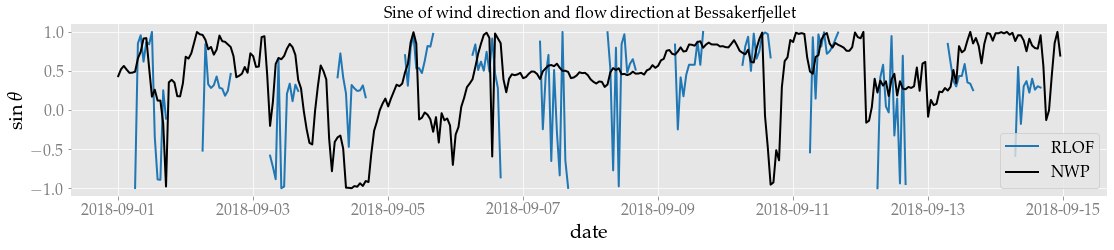

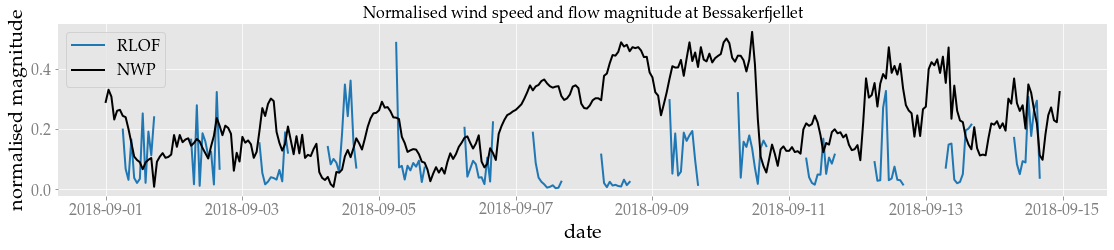

In [29]:
get_plots('bess', 'rlof_dense', 4032-24*3, 4032+24*11)

In [30]:
def all_imgtypes_plot(park: str, start_idx, stop_idx):
    plt.figure(figsize=(16,4))
    plt.title(f'Cosine of wind direction and flow direction at {park_name[park]}', fontsize=16)
    plt.plot(all_data[f'wind_direction_{park}_cos'].iloc[start_idx:stop_idx], label='NWP', color='k')
    plt.plot(all_data[f'{park}_deg_median_cos_fb_dense'].iloc[start_idx:stop_idx], label=imgType_name['fb_dense'])
    plt.plot(all_data[f'{park}_deg_median_cos_lk_dense'].iloc[start_idx:stop_idx], label=imgType_name['lk_dense'])
    plt.plot(all_data[f'{park}_deg_median_cos_dtvl1_dense'].iloc[start_idx:stop_idx], label=imgType_name['dtvl1_dense'])
    plt.plot(all_data[f'{park}_deg_median_cos_rlof_dense'].iloc[start_idx:stop_idx], label=imgType_name['rlof_dense'])
    plt.xlabel('date')
    plt.ylabel(r'$\cos{\theta}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'wind_direction_{park}_cos_allflows.png')
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title(f'Sine of wind direction and flow direction at {park_name[park]}')
    plt.plot(all_data[f'wind_direction_{park}_sin'].iloc[start_idx:stop_idx], label='NWP', color='k')
    plt.plot(all_data[f'{park}_deg_median_sin_fb_dense'].iloc[start_idx:stop_idx], label=imgType_name['fb_dense'])
    plt.plot(all_data[f'{park}_deg_median_sin_lk_dense'].iloc[start_idx:stop_idx], label=imgType_name['lk_dense'])
    plt.plot(all_data[f'{park}_deg_median_sin_dtvl1_dense'].iloc[start_idx:stop_idx], label=imgType_name['dtvl1_dense'])
    plt.plot(all_data[f'{park}_deg_median_sin_rlof_dense'].iloc[start_idx:stop_idx], label=imgType_name['rlof_dense'])
    
    plt.xlabel('date')
    plt.ylabel(r'$\sin{\theta}$')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'wind_direction_{park}_sin_allflows.png')
    plt.show()
    
    plt.figure(figsize=(16,4))
    plt.title(f'Wind speed and flow magnitude at {park_name[park]}')
    plt.plot(all_data[f'wind_speed_{park}'].iloc[start_idx:stop_idx], label='NWP', color='k')
    plt.plot(all_data[f'{park}_mag_median_fb_dense'].iloc[start_idx:stop_idx], label=imgType_name['fb_dense'])
    plt.plot(all_data[f'{park}_mag_median_lk_dense'].iloc[start_idx:stop_idx], label=imgType_name['lk_dense'])
    plt.plot(all_data[f'{park}_mag_median_dtvl1_dense'].iloc[start_idx:stop_idx], label=imgType_name['dtvl1_dense'])
    plt.plot(all_data[f'{park}_mag_median_rlof_dense'].iloc[start_idx:stop_idx], label=imgType_name['rlof_dense'])
    plt.xlabel('date')
    plt.ylabel('normalised magnitude')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'wind_speed_{park}_allflows.png')
    plt.show()

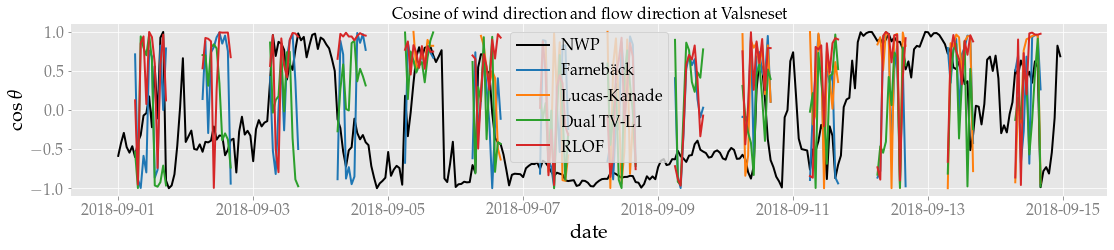

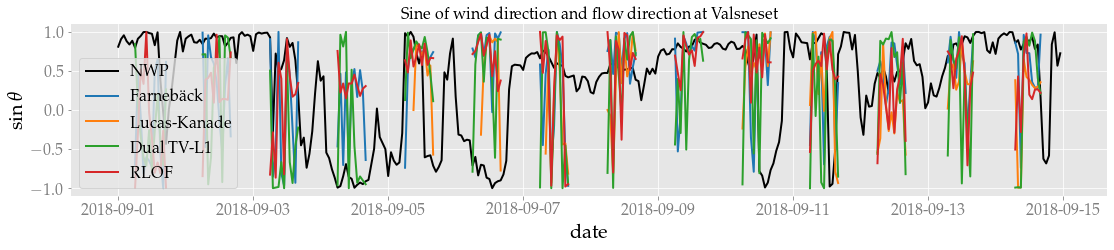

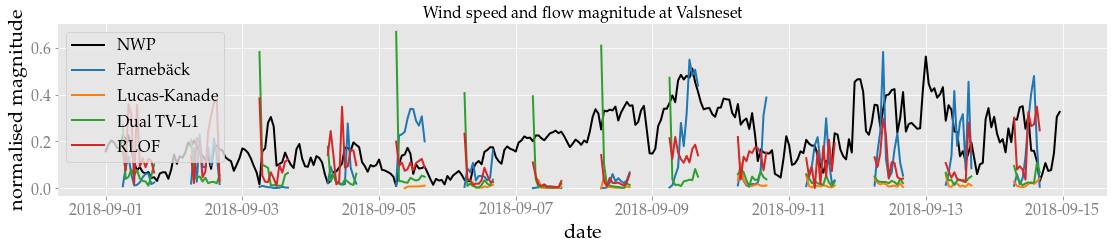

In [31]:
all_imgtypes_plot('vals', 4032-24*3, 4032+24*11)

# Old results

In [13]:
def plot_direction_arrows(direction, day):
    X, Y = np.meshgrid(np.arange(len(direction)), np.arange(1))
    U = cos_transform(direction)
    V = sin_transform(direction)

    plt.figure(figsize=(16,2))
    plt.quiver(X, Y, U, V, scale=40, headaxislength=2, headlength=3)
    plt.xlabel('hour of the day')
    plt.ylabel(starttimes_str[day])
    #plt.yticks(np.arange(0), starttimes_str[day])
    plt.xticks(np.arange(24))
    plt.yticks([], [])
    plt.title(f'Numerically predicted wind directions at {park}')
    plt.show()

def plot_direction_comparison(all_dir: pd.DataFrame, park: str, trig: str):
    df = all_dir[[col for col in all_dir.columns if trig in col]]
    df = df[[col for col in df.columns if park in col]]
    plt.figure(figsize=(16,4))
    plt.plot(df[df.columns[0]].values, label=df.columns[0])
    plt.plot(df[df.columns[1]].values, label=df.columns[1])
    plt.title(f'{trig} of optical flow calculated wind direction at {park}')
    plt.ylabel(f'{trig} of angle')
    plt.xlabel('hours')
    plt.legend()
    plt.show()
    
def get_all_dir_df(of_dirs: pd.DataFrame, data: pd.DataFrame):
    # direction dataframe with sines and cosines for img data
    dir_df = pd.DataFrame(index=of_dirs.index)
    for park in parks:
        dir_df[f'of_wind_direction_{park}_sin'] = np.sin(of_dirs[f'of_wind_direction_{park}'].values*np.pi/180)
        dir_df[f'of_wind_direction_{park}_cos'] = np.cos(of_dirs[f'of_wind_direction_{park}'].values*np.pi/180)

    # direction dataframe of sines and cosines with corrected degree value for nwp
    dir_df_nwp = pd.DataFrame(index=data.index)
    for park in parks:
        polar_directions = get_polar_directions(data, park, all_days=True)
        dir_df_nwp[f'wind_direction_sin_{park}'] = np.sin(polar_directions*np.pi/180)
        dir_df_nwp[f'wind_direction_cos_{park}'] = np.cos(polar_directions*np.pi/180)

    # the data concatenated
    return pd.concat([dir_df, dir_df_nwp], axis=1)

def plot_magnitude_comparison(all_mag: pd.DataFrame, park: str):
    plt.figure(figsize=(16,4))
    plt.plot(all_mag[f'of_wind_magnitude_{park}'], label='img')
    plt.plot(all_mag[f'production_{park}'], label='nwp')
    plt.legend()
    plt.title(f'production and optical flow magnitude at {park}')
    plt.xlabel('date')
    plt.ylabel('magnitude/production normalised')
    plt.show()
    
def get_scaled_all_mag_df(prod: pd.DataFrame):
    of_mags = get_OF_results(magnitude_path)
    prod = max_min_scale_df(prod)
    of_mags = max_min_scale_df(of_mags)
    return pd.concat([prod, of_mags], axis=1)

## Results

### Direction

#### Plot arrows of numerically predicted directions and compare to cloud videos

In [14]:
for park in parks:
    for day in np.arange(7):
        dirs = get_polar_directions(data, park, day)
        plot_direction_arrows(dirs, day)

TypeError: get_polar_directions() takes 2 positional arguments but 3 were given

#### Plot cosine and sine of directions on a timescale for both of and nwp, and compare

In [ ]:
of_dirs = get_OF_results(direction_path)
all_dir = get_all_dir_df(of_dirs, data)

In [ ]:
for park in parks:
    for trig in ['cos','sin']:
        plot_direction_comparison(all_dir, park, trig)

#### Heatmap of cosine and sine values separately

In [ ]:
sns.heatmap(all_dir[[col for col in all_dir.columns if 'sin' in col]].dropna(axis=0).corr())
plt.show()

In [ ]:
sns.heatmap(all_dir[[col for col in all_dir.columns if 'cos' in col]].dropna(axis=0).corr())
plt.show()

### Magnitude

Blurring is used in the optical flow algoithm in order to capture the general direction of the clouds. However, if there's an area beside the parks or a point in time where the parks are not covered by clouds, the blurring may give a false value that is somewhere between zero and the measurement in the nearby area with moving clouds. Another way to describe this problem is that the algorithm doesn't give zero (an easy to spot should-be-nan value), when it should.

In [ ]:
all_mag = get_scaled_all_mag_df(prod)

In [ ]:
for park in parks:
    plot_magnitude_comparison(all_mag, park)

In [ ]:
sns.heatmap(all_mag.dropna(axis=0).corr())
plt.show()